In [123]:
# import pydot, graphviz
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate, GlobalAveragePooling2D, Reshape
from tensorflow.keras.layers import Permute
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras import Model
# import torch
# from transformers import ViTFeatureExtractor, ViTModel
# from torchvision.models import vision_transformer
from keras.callbacks import ModelCheckpoint
import anchor_boxes as ab
import gc


In [124]:
# Classify the defects into 12 categories
mapping = {
    "1_chongkong" : 0,
    "2_hanfeng" : 1,
    "3_yueyawan": 2,
    "4_shuiban": 3,
    "5_youban": 4,
    "6_siban": 5,
    "7_yiwu": 6,
    "9_zhehen": 7,
    "10_yaozhed": 8,
    "scratches": 9,
    "rolled-in_scale": 10,
    "8_yahen": 11,
    "inclusion" :6

}
mapping2 = {
    0 : "Punching Hole",
    1 : "Welding Line",
    2 : "Crescent Gap",
    3 : "Water Spot",
    4 : "Oil Spot",
    5 : "Silk Spot",
    6 : "Inclusion",
    11 : "Rolled Pit",
    7 : "Crease",
    8 : "Waist Folding",
    9 : "Scratches",
    10 : "Rolled in Scale"
}

In [125]:
# Define the image size
w_factor = 2048/224.0
l_factor = 1000/224.0
w = 224
l = 224
w_factor_2 = 200/224.0
l_factor_2 = 200/224.0

In [126]:
def get_annotations(directory, class_name, idx):
    """
    Retrieves annotations from an XML file and returns a list of bounding boxes.

    Args:
        directory (str): The path to the XML file.
        class_name (str): The name of the class.
        idx (int): The index.

    Returns:
        list: A list of bounding boxes, where each box is represented as a list of values.

    Raises:
        Exception: If an error occurs while parsing the XML file.

    """
    try:
        tree = ET.parse(directory)
        root = tree.getroot()
        boxes = []
        defect = -1
        objs = root.findall('object')
        for i in objs:
            name = i.find('name').text
            defect = mapping.get(name, 12)
            if defect != 12 and defect != 11:
                box = i.find('bndbox')
                xmin = float(box.find('xmin').text)
                ymin = float(box.find('ymin').text)
                xmax = float(box.find('xmax').text)
                ymax = float(box.find('ymax').text)

               
                if xmin > xmax:
                    temp = xmin
                    xmin = xmax
                    xmax = temp
                if ymin > ymax:
                    temp = ymin
                    ymin = ymax
                    ymax = temp

                box = []
                for i in range(5):
                    box.append(-1)
                box[0] = defect
                if class_name !='inclusion':
                    box[1] = (xmin)/w_factor
                    box[2] = (ymin)/l_factor
                    box[3] = (xmax)/w_factor
                    box[4] = (ymax)/l_factor
                elif (class_name=='inclusion' and idx<217):
                    box[1] = (xmin)/w_factor
                    box[2] = (ymin)/l_factor
                    box[3] = (xmax)/w_factor
                    box[4] = (ymax)/l_factor
                
                elif (class_name=='inclusion' and idx>= 217):
                    box[1] = (xmin)/w_factor_2
                    box[2] = (ymin)/l_factor_2
                    box[3] = (xmax)/w_factor_2
                    box[4] = (ymax)/l_factor_2
                    
                boxes.append(box)
            else:
                defect = -1
        if boxes:
            return boxes
        print(class_name, idx)
        return 0
    except:
        return 0

In [127]:
# Define the path to the dataset
data_dir = 'D:\datasets\Datasets_PBL\Metal-surfaces-defects'

In [128]:
# Test Usage of get_annotations
print(get_annotations("D:\datasets\Datasets_PBL\Metal-surfaces-defects\lable\inclusion (3).xml", 'inclusion', 3))
print(get_annotations("D:\datasets\Datasets_PBL\Metal-surfaces-defects\lable\crease (1).xml", 'crease', 1))

[[6, 185.28125, 46.592, 188.890625, 53.76], [2, 97.015625, 165.536, 122.71875, 224.0]]
[[7, 107.296875, 40.768, 223.78125, 55.775999999999996], [7, 52.28125, 40.096, 77.765625, 54.656]]


In [129]:
# Get the list of categories
all_items = os.listdir(data_dir)
categories = [item for item in all_items if os.path.isdir(os.path.join(data_dir, item)) and item != 'lable']
print(categories)

['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_in_scale', 'rolled_pit', 'scratches', 'silk_spot', 'waist_folding', 'water_spot', 'welding_line']


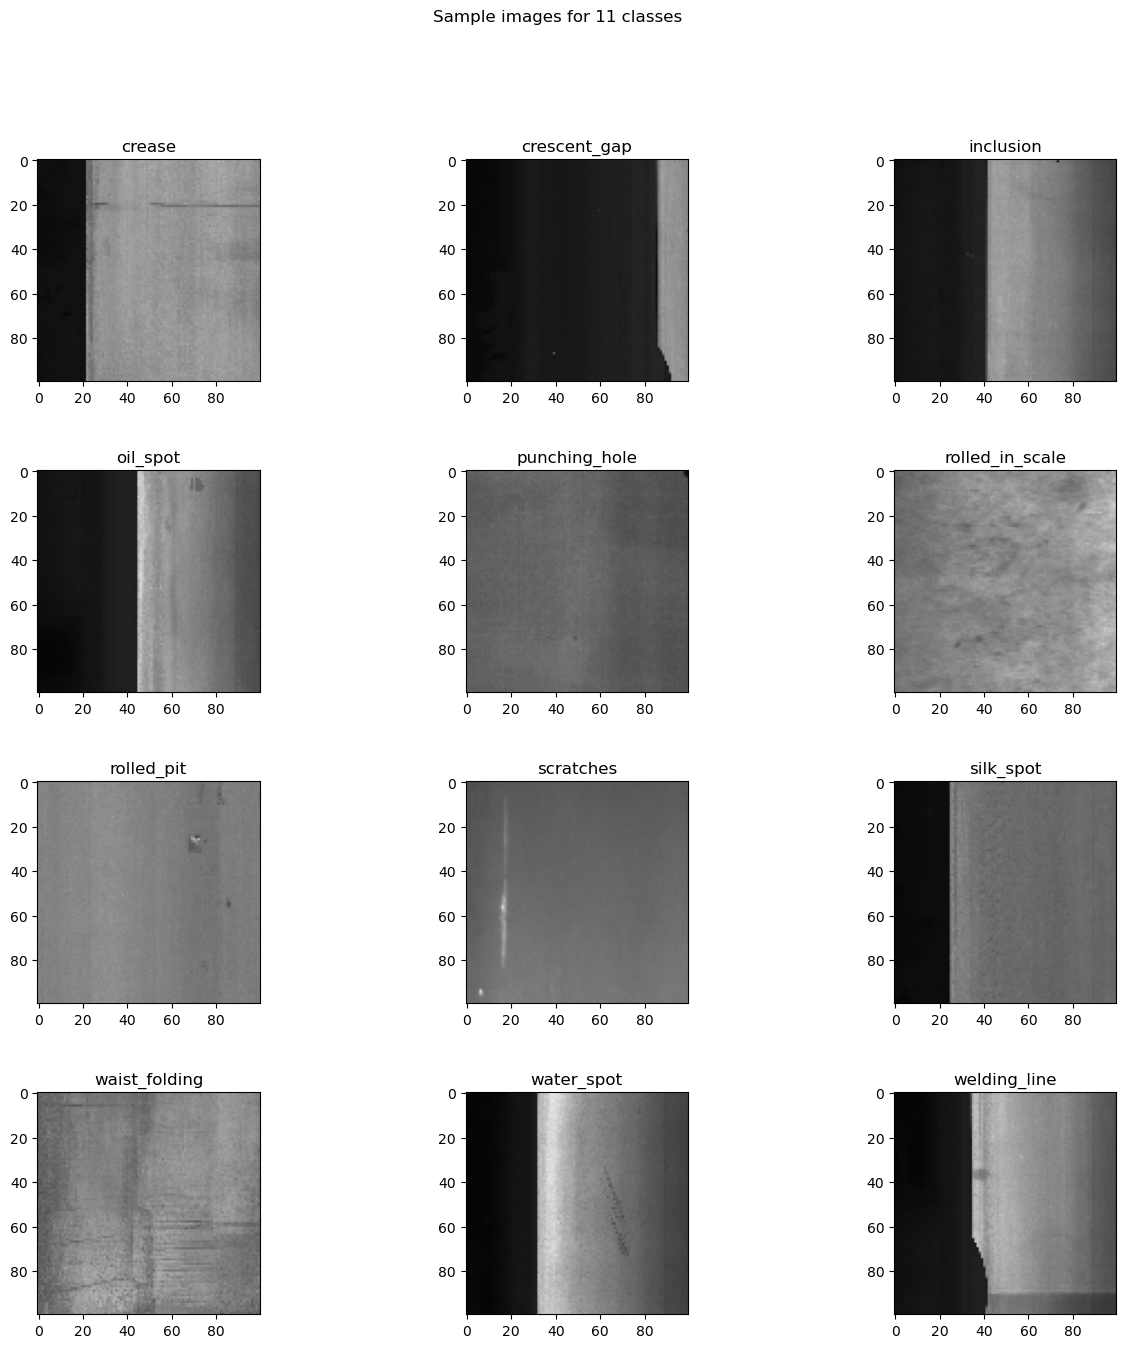

In [130]:
# Plot sample images for each category
def load_sample_images(data_dir, categories):
    """
    Load sample images from the specified data directory for the given categories.

    Args:
        data_dir (str): The path to the directory containing the image data.
        categories (list): A list of category names.

    Returns:
        list: A list of sample images loaded from the specified data directory.
    """
    sample_images = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        img_path = next(os.path.join(category_path, img) for img in os.listdir(category_path))
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        sample_images.append(img)
    return sample_images

def plot_sample_images(sample_images, categories):
    """
    Plot sample images for each category.

    Args:
        sample_images (list): List of sample images to be plotted.
        categories (list): List of categories corresponding to the sample images.

    Returns:
        None
    """
    fig = plt.figure(figsize=(15, 15))
    spec = gridspec.GridSpec(ncols=3, nrows=4, width_ratios=[1, 1, 1], wspace=0.4, hspace=0.4, height_ratios=[1, 1, 1, 1])
    fig.suptitle("Sample images for 11 classes")
    for i, img in enumerate(sample_images):
        ax = fig.add_subplot(spec[i])
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{categories[i]}")  
    plt.show()

sample_images = load_sample_images(data_dir, categories)
plot_sample_images(sample_images, categories)

In [131]:
def load_data(data_dir, categories):
    """
    Load data from the specified data directory for the given categories.

    Args:
        data_dir (str): The path to the directory containing the image data.
        categories (list): A list of category names.

    Returns:
        None
    """
    X = []
    y = []
    f=0
    for category in categories:
        category_path= os.path.join(data_dir, category)
        cnt=1
        if (f):
            break
        for img in os.listdir(category_path):
            img_path= os.path.join(category_path, img)
            img= cv2.imread(img_path)
            annotation = get_annotations(f"{data_dir}/lable/{category} ({cnt}).xml", category, cnt)
            cnt+=1
            if (len(X)==900):
                f=1
                break
            if (annotation):
                img = cv2.resize(img, (w, l))
    #             img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #             img= np.expand_dims(img, axis=0)
                X.append(img)
                y.append(annotation)
    return X, y

In [132]:
X, y = load_data(data_dir, categories)

crease 20
crease 21
crease 24
inclusion 59
inclusion 124


In [133]:
# Split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [134]:
X_train = np.array(X_train, dtype= 'float32')
X_val = np.array(X_val, dtype= 'float32')
X_test = np.array(X_test, dtype= 'float32')

In [135]:
del X, y
gc.collect()

70644

In [136]:
def split_gt(y):
    """
    Splits the ground truth annotations into separate lists for classes and dimensions.

    Args:
        y (list): The ground truth annotations.

    Returns:
        tuple: A tuple containing two lists - classes and dimensions.
               The classes list contains the class labels for each annotation.
               The dimensions list contains the dimensions (bounding boxes) for each annotation.
    """
    classes = []
    dims = []
    for i in range(len(y)):
        tmp_classes = []
        tmp_dims = []
        for j in range(len(y[i])):
            tmp_classes.append(y[i][j][0])
            tmp_dims.append(y[i][j][1:])
        classes.append(tmp_classes)
        dims.append(tmp_dims)
    return classes, dims

In [137]:
classes_train, dims_train = split_gt(y_train)
classes_val, dims_val = split_gt(y_val)
classes_test, dims_test = split_gt(y_test)

In [138]:
n = 5
scales = [32, 64, 128]
ratios = [0.5, 1, 2]


In [139]:
import importlib
ab = importlib.reload(ab)

In [140]:
def generate_dims_offsets_and_classes(dims, classes, scales, ratios, n, w, l):
    """
    Generate offsets for each image dimension based on the given scales, ratios, and number of anchor boxes.
    
    Parameters:
    - scales (list): List of scales for anchor boxes.
    - ratios (list): List of ratios for anchor boxes.
    - n (int): Number of anchor boxes per location.
    - dims (list): List of image dimensions.
    - w (int): Width of the image.
    - l (int): Length of the image.
    
    Returns:
    - offsets (list): List of offsets for each image dimension.
    """
    offsets = []
    true_classes = []
    for img_dim, cls in zip(dims, classes):
        offset, clss = ab.format_gt(np.array(img_dim), np.array(cls) , scales, ratios, n, w, l)
        offsets.append(offset)
        true_classes.append(clss)
    return offsets, true_classes

In [141]:
offset_train, cls_train  = generate_dims_offsets_and_classes(dims_train, classes_train, scales, ratios, n, w, l)
offset_val, cls_val  = generate_dims_offsets_and_classes(dims_val, classes_val, scales, ratios, n, w, l)
offset_test, cls_test  = generate_dims_offsets_and_classes( dims_test, classes_test, scales, ratios, n, w, l)

In [142]:
def extract_min(lst, index):
    """
    Extracts the minimum value from a nested list based on the specified index.
    
    Args:
        lst (list): A nested list containing numerical values.
        index (int): The index to compare the values.
        
    Returns:
        int: The minimum value found in the nested list.
    """
    minn = 10000000
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if lst[i][j][index] < minn:
                minn = lst[i][j][index]
    return minn

In [143]:
def extract_max(lst, index):
    """
    Extracts the maximum value from a nested list based on the given index.
    
    Args:
        lst (list): A nested list containing numerical values.
        index (int): The index to compare the values.
        
    Returns:
        int: The maximum value found in the nested list based on the given index.
    """
    maxx = -10000000
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if lst[i][j][index] > maxx:
                maxx = lst[i][j][index]
    return maxx

In [144]:
def maxminscaler(lst, maxx, minn, index):
    """
    Applies max-min scaling to a list of values.

    Parameters:
    lst (list): The list of values to be scaled.
    maxx (float): The maximum value for scaling.
    minn (float): The minimum value for scaling.
    index (int): The index of the value to be scaled within each sublist.

    Returns:
    list: The scaled list of values.
    """
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            lst[i][j][index] = (lst[i][j][index] - minn) / (maxx - minn)
    return lst

In [145]:
xmin_min = extract_min(offset_train, 0)
xmin_max = extract_max(offset_train, 0)
xmax_min = extract_min(offset_train, 1)
xmax_max = extract_max(offset_train, 1)
ymin_min = extract_min(offset_train, 2)
ymin_max = extract_max(offset_train, 2)
ymax_min = extract_min(offset_train, 3)
ymax_max = extract_max(offset_train, 3)

In [146]:
dims_train = maxminscaler(offset_train, xmin_max, xmin_min, 0)
dims_train = maxminscaler(offset_train, xmax_max, xmax_min, 1)
dims_train = maxminscaler(offset_train, ymin_max, ymin_min, 2)
dims_train = maxminscaler(offset_train, ymax_max, ymax_min, 3)

dims_val = maxminscaler(offset_val, xmin_min, xmin_max, 0)
dims_val = maxminscaler(offset_val, xmax_min, xmax_max, 1)
dims_val = maxminscaler(offset_val, ymin_min, ymin_max, 2)
dims_val = maxminscaler(offset_val, ymax_min, ymax_max, 3)

dims_test = maxminscaler(offset_test, xmin_min, xmin_max, 0)
dims_test = maxminscaler(offset_test, xmax_min, xmax_max, 1)
dims_test = maxminscaler(offset_test, ymin_min, ymin_max, 2)
dims_test = maxminscaler(offset_test, ymax_min, ymax_max, 3)

In [147]:
def maee(y_true, y_pred):
    """
    Calculates the mean absolute error between the true and predicted values.
    
    Parameters:
    y_true (Tensor): The true values.
    y_pred (Tensor): The predicted values.
    
    Returns:
    float: The mean absolute error.
    """
    cnt = 0
    s = 0
    for i in range(len(y_true)):
        if (tf.reduce_sum(y_true[i]) != 0):
            s += tf.reduce_sum(abs(y_true[i] - y_pred[i]))
            cnt += 1
    s /= cnt
    return s


In [148]:
def msee(y_true, y_pred):
    """
    Calculates the mean squared error (MSE) between the true labels (y_true) and the predicted labels (y_pred).

    Parameters:
    - y_true: The true labels.
    - y_pred: The predicted labels.

    Returns:
    - The mean squared error between y_true and y_pred.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    cnt = 0
    s = 0
    for i in range(len(y_true)):
        if (tf.reduce_sum(y_true[i]) != 0):
            s += tf.reduce_sum(tf.square(y_true[i] - y_pred[i]))
            cnt += 1
    s /= cnt
    return s


In [149]:
num_classes = 12

for i in range(len(cls_train)):
    cls_train[i] = np.array(cls_train[i], dtype = 'float').astype('float64').reshape((-1,1))
    cls_train[i] = to_categorical(cls_train[i], num_classes=num_classes)

for i in range(len(offset_train)):
    offset_train[i] = np.array(offset_train[i], dtype = 'float')

for i in range(len(cls_val)):
    cls_val[i] = np.array(cls_val[i], dtype = 'float').astype('float64').reshape((-1,1))
    cls_val[i] = to_categorical(cls_val[i], num_classes=num_classes)

for i in range(len(offset_val)):
    offset_val[i] = np.array(offset_val[i], dtype = 'float')

for i in range(len(cls_test)):
    cls_test[i] = np.array(cls_test[i], dtype = 'float').astype('float64').reshape((-1,1))
    cls_test[i] = to_categorical(cls_test[i], num_classes=num_classes)

for i in range(len(offset_test)):
    offset_test[i] = np.array(offset_test[i], dtype = 'float')

In [150]:
print(len(offset_train[0]))
offset_train = np.array(offset_train, dtype = 'float')
offset_val = np.array(offset_val, dtype = 'float')
offset_test = np.array(offset_test, dtype = 'float')
cls_train = np.array(cls_train, dtype = 'float')
cls_val = np.array(cls_val, dtype = 'float')
cls_test = np.array(cls_test, dtype = 'float')

225


In [151]:
from transformers import AutoImageProcessor, TFViTModel
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
extract = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

c:\Users\Toqaa\anaconda3\envs\deeplearning\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [152]:
def categorical_crossentropy2(y_true, y_pred):
    m = len(y_true)
    loss = tf.zeros([])
    for i in range(len(y_true)):
        for j in range(len(y_true[i])):
            loss += tf.keras.losses.CategoricalCrossentropy()(y_true[i][j], y_pred[i][j])

    loss /= tf.cast(m, tf.float32)
    return loss

In [153]:
def accuracy3(y_true, y_pred):
    m = len(y_true)
    accuracy = 0
    for i in range(len(y_true)):
        cnt = 0
        for j in range(len(y_true[i])):
            mask = tf.not_equal(tf.argmax(y_true[i][j], axis=-1), 11)  # Exclude class 12 (index 11)
            if not mask:
                continue
            c = tf.keras.metrics.CategoricalAccuracy()
            c.update_state(y_true[i][j], y_pred[i][j])
            accuracy += c.result()
            cnt += 1
        accuracy /= tf.cast(cnt, tf.float32)
    accuracy /= tf.cast(m, tf.float32)
    return accuracy

In [154]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8  # Allocate 80% of the available GPU memory
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [155]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('class_output_accuracy2') is not None and logs.get('class_output_accuracy2') > 0.85 \
        and logs.get('val_class_output_accuracy2') is not None and logs.get('val_class_output_accuracy2') > 0.85:
            self.model.stop_training = True

In [156]:
callbacks= myCallback()

In [157]:
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5', 
                                      save_freq='epoch', 
                                      period=10)

In [158]:
X_train_1= image_processor(X_train, return_tensors="tf")
X_val_1= image_processor(X_val, return_tensors="tf")
X_test_1= image_processor(X_test, return_tensors="tf")

In [159]:
import gc
del X_train
del X_val
del X_test
gc.collect()

6

In [160]:
X_train_1= X_train_1['pixel_values']
X_val_1 = X_val_1['pixel_values']
X_test_1 = X_test_1['pixel_values']

In [161]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [162]:
@tf.function
def extract_tf(input):
    return extract(input)

X_train_1 = tf.expand_dims(extract_tf(X_train_1)['last_hidden_state'], axis=-1)

ResourceExhaustedError:  OOM when allocating tensor with shape[630,12,197,197] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node tf_vi_t_model_3/vit/encoder/layer_._0/attention/attention/Softmax (defined at c:\Users\Toqaa\anaconda3\envs\deeplearning\lib\site-packages\transformers\tf_utils.py:72) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_extract_tf_13789]

Function call stack:
extract_tf


In [ ]:
# X_train_1 = tf.expand_dims(extract(X_train_1)['last_hidden_state'], axis=-1)
# X_val_1 = tf.expand_dims(extract(X_val_1)['last_hidden_state'], axis=-1)
# X_test_1 = tf.expand_dims(extract(X_test_1)['last_hidden_state'], axis=-1)